In [2]:
import os
from os import path as op

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import seaborn as sns
import pandas as pd
import mne

from library import config
from library.helpers import l2norm, load_patterns, import_var

Study path is set to: /raven/ptmp/fklotzsche/Experiments/vMemEcc


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# function to calculate cosine similarity between two patterns

def cosineSim(vec1, vec2):
    o = np.dot(vec1, np.transpose(vec2)) 
    if o.ndim == 0:
        o=[o]
    p = np.diag(o) / (np.linalg.norm(vec1, axis=-1) * np.linalg.norm(vec2, axis=-1))
    return p

In [5]:
# structuring data:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

event_dict = config.event_dict
cond_dict = {'Load': ['LoadLow', 'LoadHigh'],
             'Ecc': ['EccS', 'EccM', 'EccL']}

# Sensorspace decoding patterns

In [58]:

# load patterns per ecc (1 per time point)
# -> 1 array (n_subs x n_chans x n_times) per ecc
# normalize each pattern by dividing it by its L2 norm

# %matplotlib qt

picks= 'All'

patterns_per_ecc = dict()
for ecc in cond_dict['Ecc']:

    ecc_cond = ecc # 'EccL' # <<<< '' (aka empty string): all eccentricities

    sub_patterns, times = load_patterns(sub_list_str,
                                        f'LoadLow{ecc_cond}_vs_LoadHigh{ecc_cond}',
                                        picks_str=picks)
    sub_patterns_norm = np.zeros_like(sub_patterns)
    # normalize them by L2 norm to allow for unbiased averages:
    for sub in range(sub_patterns.shape[0]):
        for time in range(sub_patterns.shape[-1]):
            sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(sub_patterns[sub,:,time])
    patterns_per_ecc[ecc] = sub_patterns_norm

In [7]:
pvals = []
observeds = []
mean_perms = []
time_steps = np.int0(np.floor(np.linspace(0, len(times)-1, len(times))))

for i, t in enumerate(time_steps[1:]):
    sub_patterns_t = dict()
    for ecc in cond_dict['Ecc']:
        sub_patterns_t[ecc] = patterns_per_ecc[ecc][:, :, t-1:t].mean(axis=-1)
    vec1 = sub_patterns_t['EccS']
    vec2 = sub_patterns_t['EccL']
    
    observed_value = cosineSim(vec1.mean(axis=0), vec2.mean(axis=0))

    # permutations
    n_perms = 10000
    rng = np.random.default_rng()
    c = np.vstack([vec1, vec2])
    idx_perm = rng.permuted(np.tile(np.arange(len(c)), n_perms).reshape(n_perms, len(c)), axis=1)
    res_perm = []
    for perm in range(n_perms):
        c_perm = c[idx_perm[perm]]
        v1_perm = c_perm[:len(vec1)].mean(axis=0)
        v2_perm = c_perm[len(vec1):].mean(axis=0)
        res_perm.append(cosineSim(v1_perm, v2_perm))

    p_value = np.sum(np.array(res_perm) < observed_value) / n_perms
    pvals.append(p_value)
    observeds.append(observed_value)
    mean_perms.append(np.array(res_perm))

<AxesSubplot:>

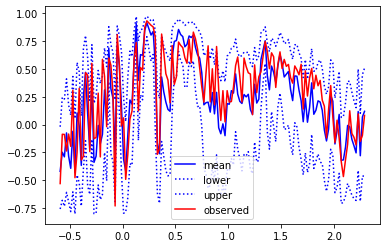

In [8]:
# put into DF and plot it

perm_arr = np.array(mean_perms)
perms_df = pd.DataFrame(np.transpose(perm_arr.squeeze()), columns=times[:-1])
perms_df = perms_df.transform(np.sort)
perm_mean = np.array(np.mean(perms_df, axis=0))
perm_lower = np.array(perms_df.iloc[np.int0(perms_df.shape[0]*0.05), :])
perm_upper = np.array(perms_df.iloc[np.int0(perms_df.shape[0] - perms_df.shape[0]*0.05), :])
dff = pd.DataFrame({'mean': perm_mean, 
                    'lower': perm_lower, 
                    'upper':perm_upper})
dff['observed'] = [o[0][0] for o in observeds]
dff.index = times[:-1]


dff.plot(style= ['-', ':', ':', '-'],   
         color= ['blue']*3 + ['red'] )   



## Pseudo-ANOVA approach (contrasting within-ecc pattern-similarity vs between-ecc similarity)

In [41]:

# calc sim for each subject with patterns of all other subjs -> mean sim per subject within
p_500 = dict()
within = dict()
within_per_sub = dict()
between_per_sub = dict()
between = dict()
for ecc in cond_dict['Ecc']:
    p_500[ecc] = patterns_per_ecc[ecc][:, :, 55]
    within_tmp = np.dot(p_500[ecc], p_500[ecc].T)
    # get lower triangle:
    within[ecc] = within_tmp[np.tril_indices(within_tmp.shape[0], k=-1)]
    # per sub: remove diagonale and take avg per sub
    within_per_sub[ecc] = within_tmp[~np.eye(within_tmp.shape[0], dtype=bool)].reshape(within_tmp.shape[0], -1).mean(axis=1)
    idx_ecc = cond_dict['Ecc'].index(ecc)
    for ecc2 in cond_dict['Ecc'][idx_ecc+1:]:
        p_500_2 = patterns_per_ecc[ecc2][:, :, 55]
        between_tmp = np.dot(p_500[ecc],p_500_2.T)
        contr_str = ecc + '_vs_' + ecc2
        # remove diagonale
        between[contr_str] = between_tmp[~np.eye(between_tmp.shape[0], dtype=bool)]
        # per sub: remove diagonale and take avg per sub
        between_per_sub[contr_str] = between_tmp[~np.eye(between_tmp.shape[0], dtype=bool)].reshape(between_tmp.shape[0], -1).mean(axis=1)
    

In [51]:
# t test between avg within and between similarities 
cont_str = 'EccS_vs_EccL'
ref_cat = 'EccS'
tval, pval = scipy.stats.ttest_rel(between_per_sub[contr_str],
                                   within_per_sub[ref_cat])
print(f'contrast: {cont_str} (reference category (within): {ref_cat})')
print(f'T: {tval} --- p = {pval}')

contrast: EccS_vs_EccL (reference category (within): EccS)
T: 2.455329337649968 --- p = 0.023351787093454146


I do not really think that this is a very reliable measure though ... 
It seems arbitrary which ecc is the reference category, also samples are far from 
independent.  
For now, I've only done it for a single timepoint. Rather won't do it for the rest ...  
Probably better to do a real ANOVA:


## Actual ANOVA (Ecc x Channel)

In [ ]:
p_out = []
for i in range(len(times)):
    inp = np.hstack([patterns_per_ecc[e][:, :, i] for e in cond_dict['Ecc']])
    f_vals, p_vals = mne.stats.f_mway_rm(inp,
                                        factor_levels=[3, 60],
                                        effects='A*B',
                                        correction=True)
    p_out.append(p_vals)    



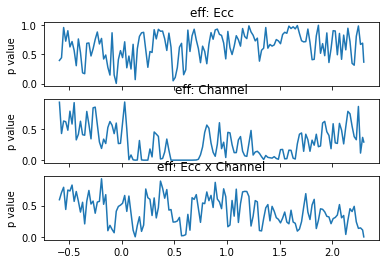

In [66]:

fig, axes = plt.subplots(3,1, sharex=True)

eff_names = ['Ecc', 'Channel', 'Ecc x Channel']

for eff_n, ax, i in zip(eff_names, axes, range(len(eff_names))):
    ax.plot(times, np.array(p_out)[:, i])
    ax.set_ylabel('p value')
    ax.set_title(f'eff: {eff_n}')

We could try to correct this for MC via a CBP test. But looking at this, it's not a 
strong effect anyway. If at all. 

# CDA Pattern Differences between Eccs

In [6]:
#1: Load "difference" epochs for all chans per Ecc

def get_epos(subID, epo_part, signaltype, condition, event_dict, picks_str):
    if signaltype == 'uncollapsed':
        fname = op.join(config.paths['03_preproc-rejectET'],
                        epo_part,
                        'cleaneddata',
                        f"{subID}-{epo_part}-rejepo-epo.fif")
    elif signaltype in ['collapsed', 'difference']:
        fname = op.join(config.paths['03_preproc-pooled'],
                        epo_part,
                        signaltype,
                        f"{subID}-{epo_part}-{signaltype}-epo.fif")
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    # pick channel selection:
    if (picks_str is not None) and (picks_str != 'All'):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)

    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)

epos_ecc = dict()
for ecc in cond_dict['Ecc']:
    epos = []
    for subID in sub_list_str:
        epos_ = get_epos(subID,
                         epo_part='stimon',
                         signaltype='collapsed',
                         condition=ecc,
                         event_dict=config.event_dict,
                         picks_str='All')
        epos.append(epos_)
    epos_ecc[ecc] = epos

In [39]:
%load_ext line_profiler

In [264]:
%%capture --no-stdout

#2: Calculate similarity of evokeds per ID

epos1 = [e.copy().crop(-0.3, 2.2).decimate(5, verbose=False) for e in epos_ecc['EccS']]
epos2 = [e.copy().crop(-0.3, 2.2).decimate(5, verbose=False) for e in epos_ecc['EccL']]
n_perms = 1_000
sims_orig = np.zeros((len(sub_list_str), len(epos1[0].times)))
sims_rand = np.zeros((len(sub_list_str), len(epos1[0].times), n_perms))
for idx_sub, epo1, epo2 in zip(range(len(sub_list_str)),
                                        epos1,
                                        epos2):
    print(f'Running Subject {sub_list_str[idx_sub]}.')
    
    evo1_orig = epo1.copy().crop(-0.3, 2.2).average().data
    evo2_orig = epo2.copy().crop(-0.3, 2.2).average().data
    
    # normalize it:
    evo2_orig = evo2_orig / l2norm(evo2_orig, axis=0)
    evo1_orig = evo1_orig / l2norm(evo1_orig, axis=0)

    sims_orig[idx_sub, :] = cosineSim(evo1_orig[:, :].T, evo2_orig[:, :].T)


    # Permutations:
    comb = np.concatenate([epo1._data, epo2._data], axis=0)

    rng = np.random.default_rng()
    idx_perm = rng.permuted(np.tile(np.arange(len(comb)), n_perms).reshape(n_perms, len(comb)), axis=1)
    # comb_tmp = comb[idx_perm]


    for idx_rep in range(n_perms):
        ii = idx_perm[idx_rep]
        comb_tmp = comb[ii]
        evo1_rand = comb_tmp[:epo1._data.shape[0],...].mean(axis=0)
        evo2_rand = comb_tmp[epo1._data.shape[0]:,...].mean(axis=0)
        evo1_rand = evo1_rand / l2norm(evo1_rand, axis=0)
        evo2_rand = evo2_rand / l2norm(evo2_rand, axis=0)
        
        sims_rand[idx_sub, :, idx_rep] = cosineSim(evo1_rand[:, :].T, evo2_rand[:, :].T)
            



            





Running Subject VME_S01.
Running Subject VME_S02.
Running Subject VME_S03.
Running Subject VME_S04.
Running Subject VME_S05.
Running Subject VME_S06.
Running Subject VME_S07.
Running Subject VME_S08.
Running Subject VME_S09.
Running Subject VME_S10.
Running Subject VME_S15.
Running Subject VME_S16.
Running Subject VME_S17.
Running Subject VME_S18.
Running Subject VME_S20.
Running Subject VME_S21.
Running Subject VME_S23.
Running Subject VME_S24.
Running Subject VME_S25.
Running Subject VME_S26.
Running Subject VME_S27.


In [256]:
from turtle import color

pval_lower = np.sum(sims_rand  < sims_orig[..., np.newaxis], axis=-1)
pval_upper = np.sum(sims_rand  > sims_orig[..., np.newaxis], axis=-1)
pval = np.minimum(pval_lower, pval_upper) / n_perms
pval_plot, pval_fdrcorr = mne.stats.fdr_correction(pval, 0.05)


NameError: name 'sims_rand' is not defined

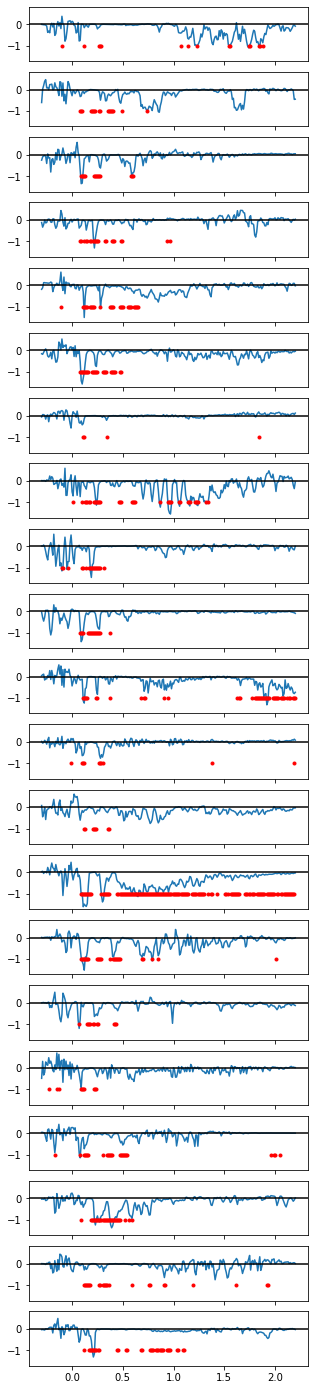

In [9]:

fig, axes = plt.subplots(21,1, figsize=(5,25), sharey=True, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(epos1[0].times, np.array([sims_orig_coll[i] - np.median(sims_rand_coll[i], axis=(-1))]).T)
    ax.axhline(0, color='black')
    ax.plot(epos1[0].times[pval_plot[i]], np.repeat(-1, np.sum(pval_plot[i])), 'r.')



In [10]:
diff = sims_orig_coll - np.median(sims_rand_coll, axis=(-1))
T_vals, clusters, p_vals, H0 = mne.stats.permutation_cluster_1samp_test(diff, out_type='mask', n_permutations=10000)



Using a threshold of 2.085963
stat_fun(H1): min=-7.705063 max=0.523756
Running initial clustering
Found 13 clusters
Permuting 9999 times...


/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):
/u/fklotzsche/conda-envs/mne/lib/python3.9/site-packages/mne/externals/tqdm/__init__.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(__version__) < LooseVersion('4.36'):


  0%|          |  : 0/9999 [00:00<?,       ?it/s]

Computing cluster p-values
Done.


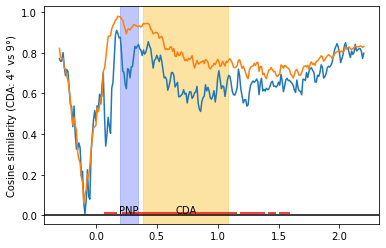

In [12]:

fig, ax = plt.subplots(1,1)
ax.plot(epos1[0].times, np.array([sims_orig_coll.mean(axis=0), sims_rand_coll.mean(axis=(0, -1))]).T)
ax.set_ylabel('Cosine similarity (CDA: 4° vs 9°)')

ytick_range = ax.get_ylim()
idx_sign_clusters = np.argwhere(p_vals < 0.05)


sign_cluster_times = [epos1[0].times[clusters[idx[0]]][[0,-1]] for idx in idx_sign_clusters]
for sc in sign_cluster_times:
            xmin = sc[0]
            xmax = sc[-1]
            ax.hlines(ytick_range[0] + 0.05*np.ptp(ytick_range), xmin=xmin, xmax=xmax, color='red', 
                    label='sign.')
ax.axhline(0, color='black')

for erp in ['cda', 'pnp']:
        _start = float(import_var(erp + '_sign_cluster_t_start')) * 1e-3
        _end = float(import_var(erp + '_sign_cluster_t_end')) * 1e-3
        ax.axvspan(xmin=_start, xmax=_end, ymin=-1, ymax=1, color=config.colors[erp.upper()], alpha=0.5)
        ax.text(x=np.mean([_start, _end]), y=0.01, s=erp.upper(), ha='center')

# ax.legend(labels=['original', 'permuted (median)', 'p < .05 (CBP corrected)'])

In [15]:

epo1._data.shape


(226, 60, 251)

In [187]:
epos_coll = dict()
for cond in cond_dict['Ecc'] + cond_dict['Load']:
    epos = []
    for subID in sub_list_str:
        epos_ = get_epos(subID,
                        epo_part='stimon',
                        signaltype='collapsed',
                        condition=cond,
                        event_dict=config.event_dict,
                        picks_str='All')
        epos.append(epos_)
    epos_coll[cond] = epos

In [242]:
from collections import defaultdict
from library import helpers

def get_evokeds_dict(epo_part, sub_list,  plt_dict, data_type="difference"):
    evokeds = defaultdict(list)
    for sub in sub_list: 
        if data_type not in ["difference", "collapsed"]:
            raise ValueError(f"Invalid data type '{data_type}'. Has to be either 'difference' or 'collapsed'.")
        subID = 'VME_S%02d' % sub
        fname = op.join(config.paths['03_preproc-pooled'], epo_part,
                        data_type, f'{subID}-{epo_part}-{data_type}-epo.fif')
        epos = mne.read_epochs(fname, verbose=False)
        epos.pick_channels(plt_dict['picks'])
        epos.crop(plt_dict[epo_part]['xmin'], plt_dict[epo_part]['xmax'])
        event_dict = helpers.get_event_dict(epos.event_id)
        for load in ['LoadLow', 'LoadHigh']:
            evoked_load = epos[event_dict[load]].copy().average()   
            evokeds[load].append(evoked_load)
            for ecc in ['EccS', 'EccM', 'EccL']:
                if load == 'LoadLow':  # we don't want to do this twice
                    evoked_ecc = epos[event_dict[ecc]].copy().average()  
                    evokeds[ecc].append(evoked_ecc)
                # Interaction:
                evoked_interac = epos[event_dict[load]][event_dict[ecc]].copy()
                evoked_interac = evoked_interac.average()
                evokeds[load+ecc].append(evoked_interac)
        evokeds['all'].append(epos.copy().average())
    return(evokeds)


def plot_main_effect_load(evokeds, picks, ax, sign_cluster=None):
    """Plot the main effect of Memory Load on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.
    """
    conds = ['LoadLow', 'LoadHigh']
    plt_names = ['2', '4']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict,
                                picks=picks,
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=False,
                                ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False,
                                styles={cond: {"linewidth": 0.5} for cond in plt_dict.keys()},
                                legend=False
                                )
    # Fake legend:
    # custom_lines = [matplotlib.lines.Line2D([0], [0], color=config.colors['LoadLow'], lw=2),
    #                 matplotlib.lines.Line2D([0], [0], color=config.colors['LoadHigh'], lw=2)]
    # ax.legend(handles=custom_lines,
    #           #labels=conds,
    #           loc=1, 
    #           prop={'size': config.plt_label_size},
    #           title='Size Memory Array',
    #           labels=['2 items', '4 items'],
    #           title_fontsize=config.plt_label_size)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color='red', alpha=0.1)
    # ax.set_aspect(0.25)
    ax.set_title('')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    ax.set_ylabel('CDA amplitude (' + chr(956) + 'V)', fontname=config.plt_fontname)

    # plt.xticks(fontsize=config.plt_label_size, fontname=config.plt_fontname)
    # plt.yticks(fontsize=config.plt_label_size, fontname=config.plt_fontname)
    for tick in ax.get_xticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)
    for tick in ax.get_yticklabels():
        tick.set_fontname(fontname=config.plt_fontname)
        tick.set_fontsize(config.plt_label_size)
                          


def plot_main_effect_ecc(evokeds, picks, ax, sign_cluster=None):
    """Plot the main effect of Eccentricity on the lateralized ERP.

    Paramteters
    -------
    evokeds : dict
        Dictionnary with Evokeds objects. Can be loaded from disc by using `get_evokeds_dict`.
    ax : Axes instance
        Axes object to plot into.
    sign_cluster : tuple
        Tuple with start and end time of the sign. cluster. If provided, the plot gets overlaid
        with a red box to indicate the time of the cluster. If `None` (default), no box is plotted.
    """
    # Main Effect Ecc:
    conds = ['EccS', 'EccM', 'EccL']
    plt_names = ['4°', '9°', '14°']
    plt_dict = {nn: evokeds[k] for k, nn in zip(conds, plt_names)}
    res = mne.viz.plot_compare_evokeds(plt_dict,
                                picks=picks,
                                combine='mean', 
                                colors = {k: config.colors[k] for k in plt_dict.keys()},
                                vlines=[0, 0.2, 2.2],
                                ci=False,
                                #ylim=dict(eeg=[-1.5,1.5]),
                                title=None, 
                                axes = ax, 
                                show = False, 
                                truncate_yaxis=False, 
                                truncate_xaxis=False,
                                styles={cond: {"linewidth": 0.5} for cond in plt_dict.keys()},
                                legend=False
                                )
    # ax.legend(loc=1, prop={'size': config.plt_label_size}, 
    #           title='Eccentricity', ncol=3)
    ax.axvspan(0, 0.2, color='grey', alpha=0.3)
    ax.axvspan(2.2, 2.3, color='grey', alpha=0.3)
    # ax.vlines([0,0.2,2.2], *[-1.5,1.5], linestyles='--', colors='k',
    #             linewidth=1., zorder=1)
    if sign_cluster is not None:
        ax.axvspan(sign_cluster[0], sign_cluster[-1], color='red', alpha=0.1)
    # ax.set_aspect(0.25)
    ax.set_title('')
    ax.set_ylabel('ERP amplitude (' + chr(956) + 'V)')
    ax.xaxis.label.set_size(config.plt_label_size)
    ax.yaxis.label.set_size(config.plt_label_size)
    plt.xticks(fontsize=config.plt_label_size)
    plt.yticks(fontsize=config.plt_label_size)



In [ ]:

# define dict used for plotting of different epo parts:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0, 
      'xmin': -0.2, 
      'xmax': 2.3}
plt_dict['stimon'] = pp
plt_dict['picks'] = config.chans_CDA_dict['Left']


evos = get_evokeds_dict('stimon', sub_list, plt_dict)

In [237]:
plt_dict['picks'] = config.chans_CDA_all


In [238]:
evos_colla = get_evokeds_dict('stimon', sub_list, plt_dict, data_type="collapsed")

In [265]:
diff_load = [eL._data.mean(axis=0) - eS._data.mean(axis=0) for eL, eS in zip(epos_coll['LoadHigh'], epos_coll['LoadLow'])]
diff_ecc = [eL._data.mean(axis=0) - eS._data.mean(axis=0) for eL, eS in zip(epos_coll['EccL'], epos_coll['EccS'])]


evo_diff_load = np.stack(diff_load).mean(axis=0)
evo_diff_ecc = np.stack(diff_ecc).mean(axis=0)

# normalize it:
#evo_diff_load = evo_diff_load / l2norm(evo_diff_load, axis=0)
#evo_diff_ecc = evo_diff_ecc / l2norm(evo_diff_ecc, axis=0)

epo_dummy = epos_coll['LoadLow'][0]


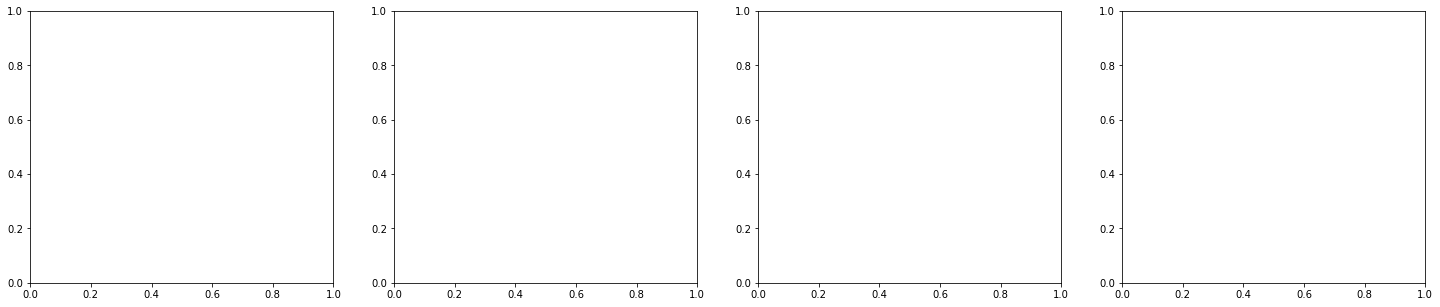

In [269]:
# First set up the figure, the axis, and the plot element we want to animate
fig, axes = plt.subplots(1,4, figsize=(25,5))



# initialization function: plot the background of each frame
def init():
    return 1.3

# animation function. This is called sequentially
def animate(i, ax=axes, fig=fig):
    ax[0].cla()
    ax[1].cla()
    ax[2].cla()
    ax[3].cla()
    idx = 0+i*14
    time_str = str(epo_dummy.times[i])
    out, _ = mne.viz.plot_topomap(data=evo_diff_load[:,i], 
                         pos=epo_dummy.info,
                         # vmin=-0.5, vmax=0.5,
                         show=False, axes=ax[1])
    out2, _ = mne.viz.plot_topomap(data=evo_diff_ecc[:,i], 
                         pos=epo_dummy.info,
                         # vmin=-0.5, vmax=0.5,
                         show=False, axes=ax[2])
    fig.suptitle(time_str)
    ax[1].text(x=0, y=0.05, s='load effect (high - low)', ha='center')
    ax[2].text(x=0, y=0.05, s='ecc effect (14° - 4°)', ha='center')
    plot_main_effect_ecc(evos_colla, picks='all', ax=ax[3])
    plot_main_effect_load(evos, picks='all', ax=ax[0])
    ax[0].axvline(epo_dummy.times[i])
    ax[3].axvline(epo_dummy.times[i])
    return (out)

In [270]:
from matplotlib import animation, rc
from IPython.display import HTML
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, frames=range(200,1500,50), interval=300)

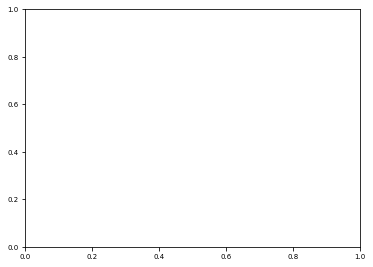

In [271]:
%%capture  --no-display
HTML(anim.to_html5_video())

In [ ]:
#3: Calc permutations: 
#   (a) randomly distribute epochs to 2 conditions
#   (b) claculate similarity of evokeds per ID, store, repeat

In [276]:
from pathlib import Path
import os 

In [381]:
ddir = Path('/raven', 'ptmp', 'fklotzsche', 'delmedir', 'AdamRep', '2pxhm', 'osfstorage', 'Exp1', 'data')
subs = os.listdir(ddir)

['34',
 '37',
 '85',
 '80',
 '119',
 '205_reject_all_arfs',
 '88',
 '107',
 '83',
 '145',
 '187',
 '7',
 '137',
 '208',
 '133',
 '56',
 '175',
 '171',
 '51',
 '125',
 '21',
 '121',
 '163',
 '59',
 '24',
 '214',
 '210',
 '70',
 '78',
 '73',
 '43',
 '6',
 '3',
 '108',
 '46',
 '146',
 '188',
 '41',
 '11',
 '138',
 '209',
 '49',
 '97',
 '126',
 '14',
 '92',
 '164',
 '160',
 '110',
 '17',
 '152',
 '65',
 '194',
 '190',
 '60',
 '215',
 '140',
 '211',
 '68',
 '203',
 '63',
 '33',
 '53(funny raws)',
 '5',
 '2',
 '36',
 '31',
 '109',
 '39',
 '87',
 '189',
 '82',
 '135',
 '127',
 '123',
 '169',
 '55',
 '165',
 '50',
 '115',
 '111',
 '153',
 '58',
 '191',
 '216',
 '23',
 '141',
 '212',
 '4',
 '1',
 '204',
 '26',
 '74',
 '29',
 '45',
 '178',
 '40',
 '128',
 '124',
 '166',
 '96',
 '116',
 '13',
 '91',
 '112',
 '158',
 '154',
 '150',
 '196',
 '199_reject_all_arfs',
 '104',
 '99',
 '100',
 '217',
 '16',
 '94',
 '142',
 '213',
 '184',
 '180',
 '130',
 '202_reject_all_arfs',
 '172',
 '67',
 '62',
 '32'

In [293]:
fname = 'erp_singletrial.mat'

In [296]:
import scipy
import mat73

In [297]:
dd = mat73.loadmat(Path(ddir, fname))

In [324]:
dd['erp'].keys()

dict_keys(['allChans', 'arf', 'baseline', 'calib', 'data', 'event', 'eventCodes', 'eventTimes', 'filtered_data', 'leftChans', 'nChans', 'pnts', 'post_timepoint', 'pre_timepoint', 'rateAcq', 'rightChans', 'srate', 'trial', 'trialCodes'])

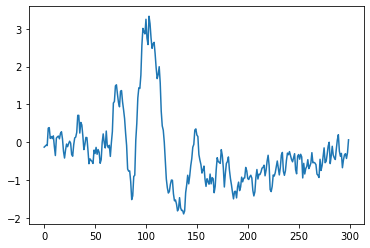

In [366]:
evo_contra = dd['erp']['trial']['R_S6'][:, chan_idx['left'], :].mean(axis=(0,1))
evo_ipsi = dd['erp']['trial']['R_S6'][:, chan_idx['right'], :].mean(axis=(0,1))
plt.plot(evo_contra - evo_ipsi)

In [332]:
chans = dd['erp']['allChans']
chan_idx = {c: chans.index(c) for c in chans}
chan_idx
chans_left = [c for c in chans if c[-1] not in ['R', 'z', 'M'] and (c[-1] == 'L' or int(c[-1]) % 2)]
chans_right = [c for c in chans if c[-1] not in ['L', 'z', 'M'] and (c[-1] == 'R' or not int(c[-1]) % 2)]
chan_idx['left'] = [chans.index(c) for c in chans_left]
chan_idx['right'] = [chans.index(c) for c in chans_right]

In [360]:
chan_idx['left'] = [chans.index(c) for c in chans_left]
chan_idx['right'] = [chans.index(c) for c in chans_right]